<a href="https://colab.research.google.com/github/AkshataKishore/R/blob/main/Strength_of_Concrete_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mounting the data  to drive 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"
%cd /content/drive/My Drive/


## Importing the relevant libraries 

In [4]:
import time,os,json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') # random state
SEED=100
time_start_notebook = time.time()
home = os.path.expanduser('~')
[(x.__name__,x.__version__) for x in [np,pd,sns]]

[('numpy', '1.19.5'), ('pandas', '1.1.5'), ('seaborn', '0.11.1')]

## Installing the Relevant libraries 

In [15]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## model evaluation
    !pip install -U watermark
    !pip install -U xgboost
    !pip install -U eli5
    !pip install -U shap
    !pip install -U pdpbox
    !pip install -U yellowbrick
    !pip install -U lime
    !pip install -U explainerdashboard
    #### print
    print('Environment: Google Colaboratory.')

# NOTE: If we update modules in gcolab, we need to restart runtime.

# Reading the Data Set 

In [5]:
df = pd.read_csv('concrete_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              1030 non-null   float64
 1   Blast Furnace Slag  1030 non-null   float64
 2   Fly Ash             1030 non-null   float64
 3   Water               1030 non-null   float64
 4   Superplasticizer    1030 non-null   float64
 5   Coarse Aggregate    1030 non-null   float64
 6   Fine Aggregate      1030 non-null   float64
 7   Age                 1030 non-null   int64  
 8   Strength            1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


## Looking for the number of columns in data 

In [7]:
df.columns

Index(['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer',
       'Coarse Aggregate', 'Fine Aggregate', 'Age', 'Strength'],
      dtype='object')

## Looking for missing values in the dataset 

In [8]:
df.isnull().sum()

Cement                0
Blast Furnace Slag    0
Fly Ash               0
Water                 0
Superplasticizer      0
Coarse Aggregate      0
Fine Aggregate        0
Age                   0
Strength              0
dtype: int64

## Creating Interaction Variable 

In [9]:
df['Water_Cement_ratio']=df['Water']/df['Cement']

## Creating the Target and Features 

In [ ]:
# Input/independent variables
X = df.drop('Strength', axis = 1)   # here we are droping the output feature as this is the target and 'X' is input features, the changes are not 
                                              # made inplace as we have not used 'inplace = True'
y = df['Strength'] 

In [11]:
from sklearn.model_selection import  train_test_split, cross_val_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Splitting the Data in to test and train and scaling the data 

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=2)

from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)

## Creating a Regressor model 

In [39]:
from sklearn.neural_network import MLPRegressor
random_state = 0
mlp = MLPRegressor(hidden_layer_sizes=[20] * 2, max_iter=2000, early_stopping=True, 
                   n_iter_no_change=100, validation_fraction=0.2,
                   solver='adam', activation="relu", random_state=random_state,
                   learning_rate_init=0.001)
mlp.fit(X_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[20, 20], max_iter=2000,
             n_iter_no_change=100, random_state=0, validation_fraction=0.2)

## Installing the Altheia package for unwrapping the DNN https://github.com/SelfExplainML/Aletheia

In [31]:
! pip install git+https://github.com/SelfExplainML/aletheia.git

  Cloning https://github.com/SelfExplainML/aletheia.git to /tmp/pip-req-build-3sqg48vw
  Running command git clone -q https://github.com/SelfExplainML/aletheia.git /tmp/pip-req-build-3sqg48vw
     |████████████████████████████████| 22.2MB 1.3MB/s 
  Created wheel for aletheia: filename=aletheia-1.0-cp36-none-any.whl size=4337565 sha256=ee268612c4f05e056204fb13c923b022c0fcfd6c4e04bacac28cbfc0893ee51f
  Stored in directory: /tmp/pip-ephem-wheel-cache-e64ufmgt/wheels/56/2c/40/546b7be2a0eef4a358c23f4f96c7dfae1e3a8debf4e90fec69
Successfully built aletheia
ERROR: yellowbrick 1.2.1 has requirement scikit-learn<0.24,>=0.20, but you'll have scikit-learn 0.24.1 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [50]:
from aletheia import *
clf = UnwrapperRegressor(mlp.coefs_, mlp.intercepts_,feature_names=X_train.columns)
clf.fit(X_train_norm, y_train)

## Looking for the Summary from the MLP model 

In [51]:

clf.summary()

Count  Response Mean  Response Std    Local MSE   Global MSE
0     78.0      33.234359     11.198257  1225.827346  1582.730352
1     35.0      16.390571      7.993431   329.092573  1580.441054
2     33.0      26.186364      8.280435   749.006454  1578.265153
3     33.0      38.252727      8.282945  1524.940613  1581.361548
4     32.0      34.664062     12.270249  1347.175955  1582.880232
..     ...            ...           ...          ...          ...
142    1.0      25.080000      0.000000   635.373513  1596.331873
143    1.0      71.620000      0.000000  5122.224017  1593.358493
144    1.0      25.420000      0.000000   642.296056  1572.605199
145    1.0      28.600000      0.000000   817.450239  1587.950156
146    1.0      68.100000      0.000000  4653.015035  1581.100762

[147 rows x 5 columns]

## Pairplots from the Regressor model 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


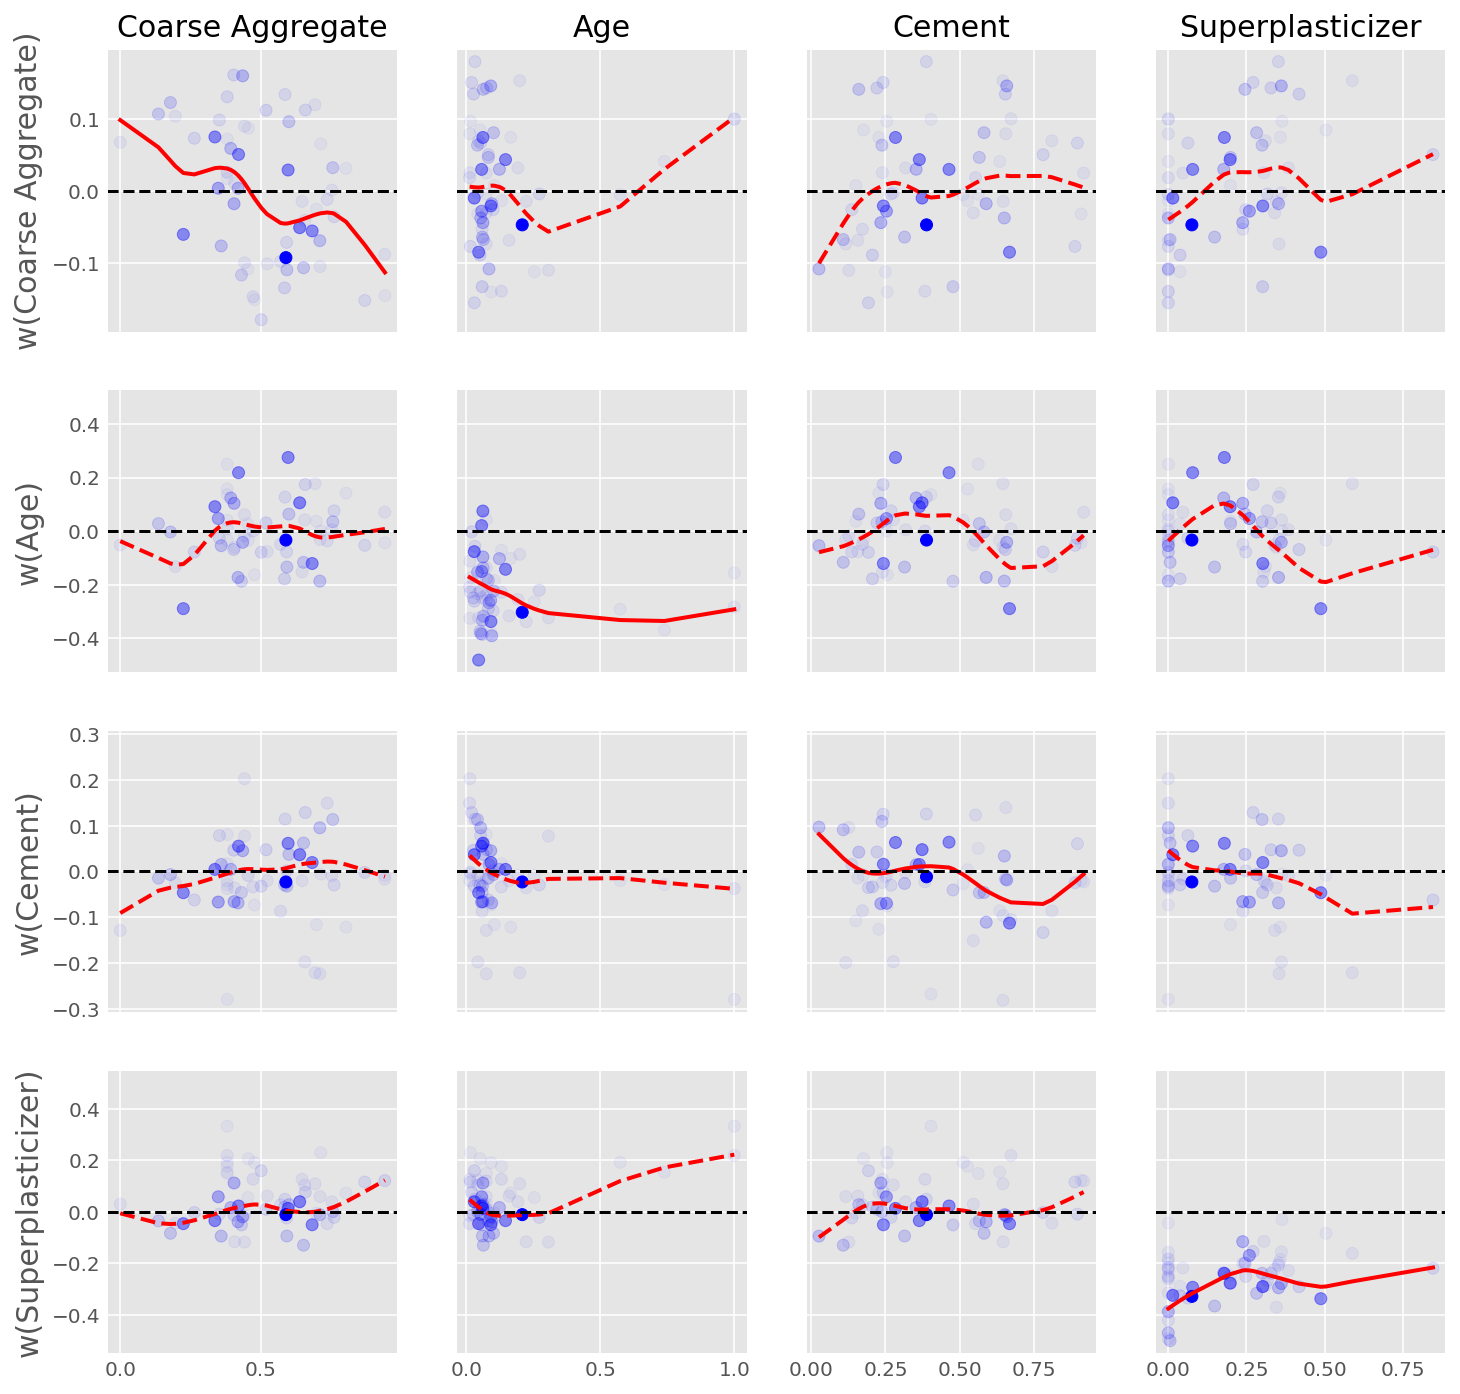

In [58]:
clf.pair_plot([6, 8, 1,5], nllms=60, offdiagsmooth=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


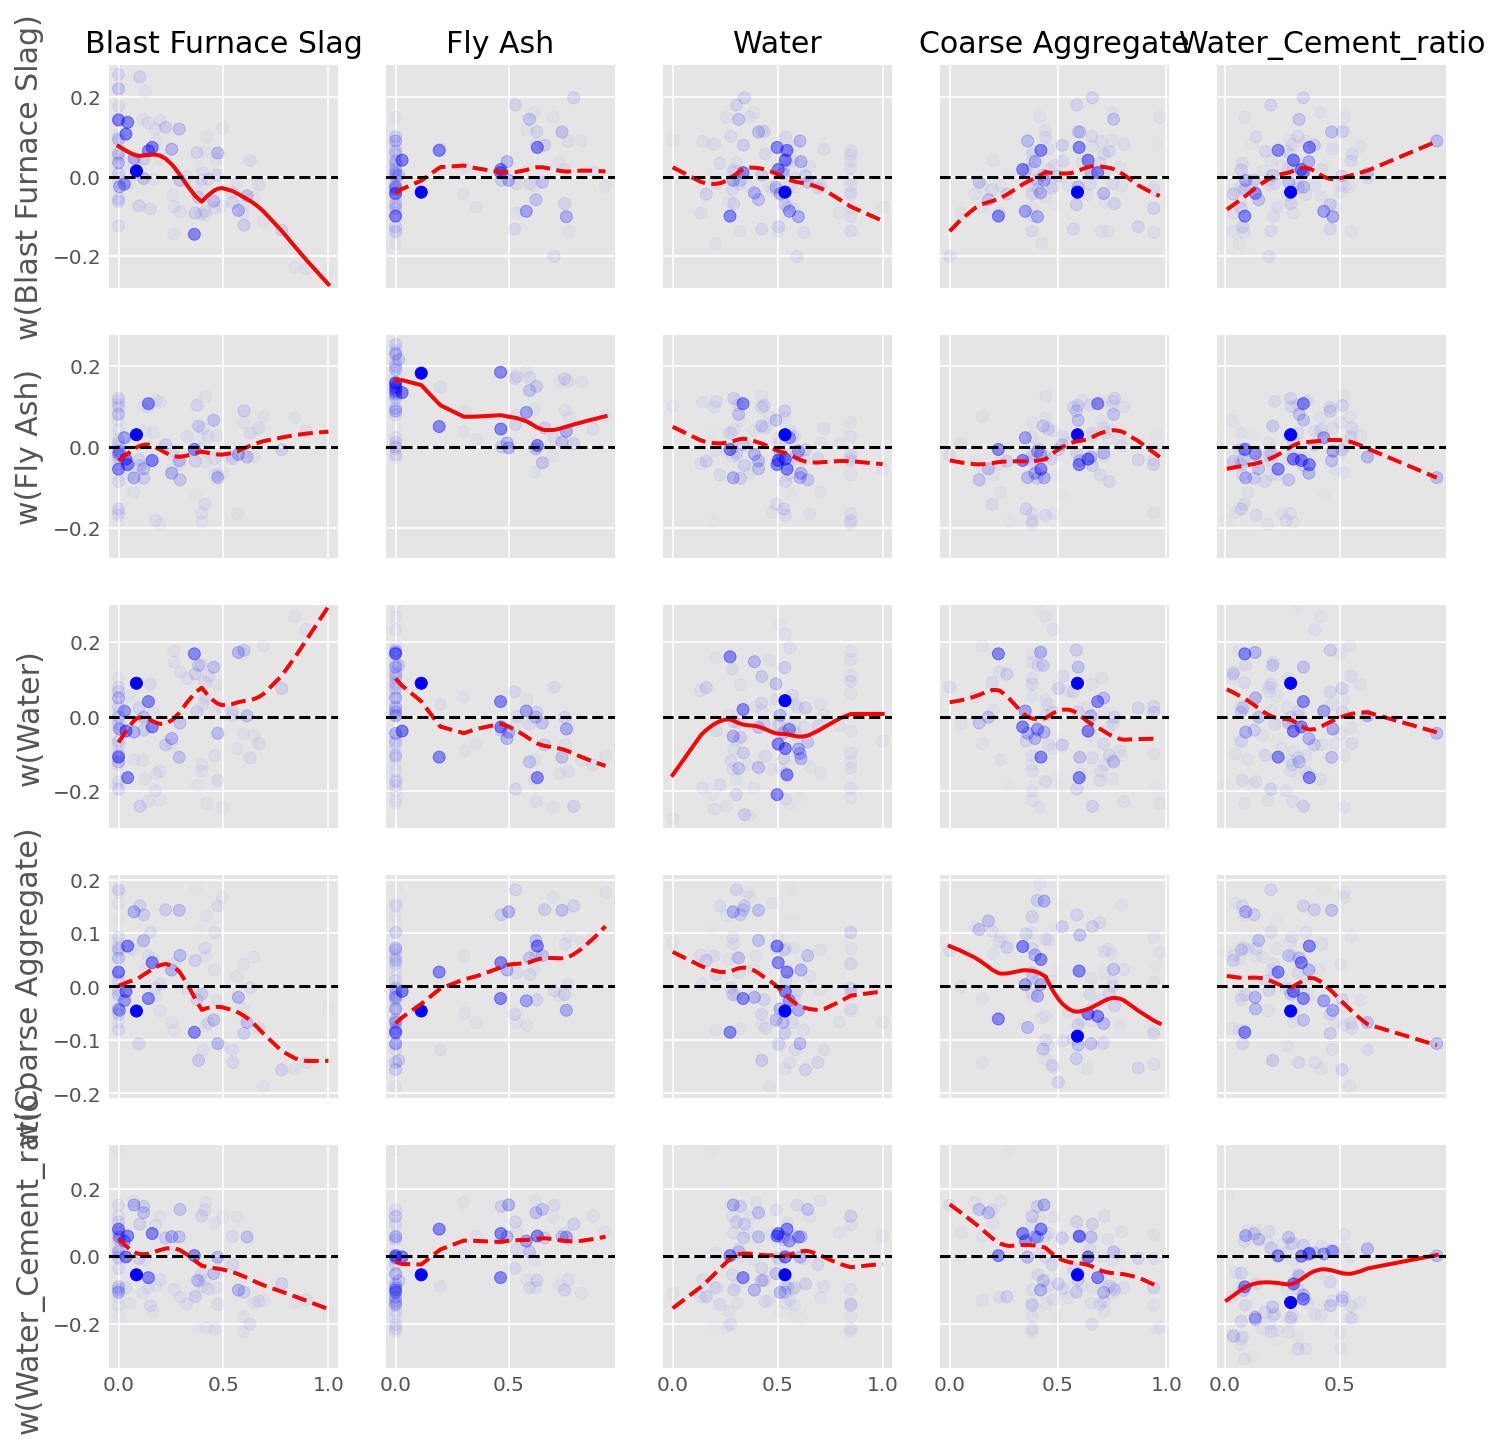

In [86]:
clf.pair_plot([2, 3, 4,6,9], nllms=99, offdiagsmooth=True)

## Intercept from the MLP Regression visualized 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


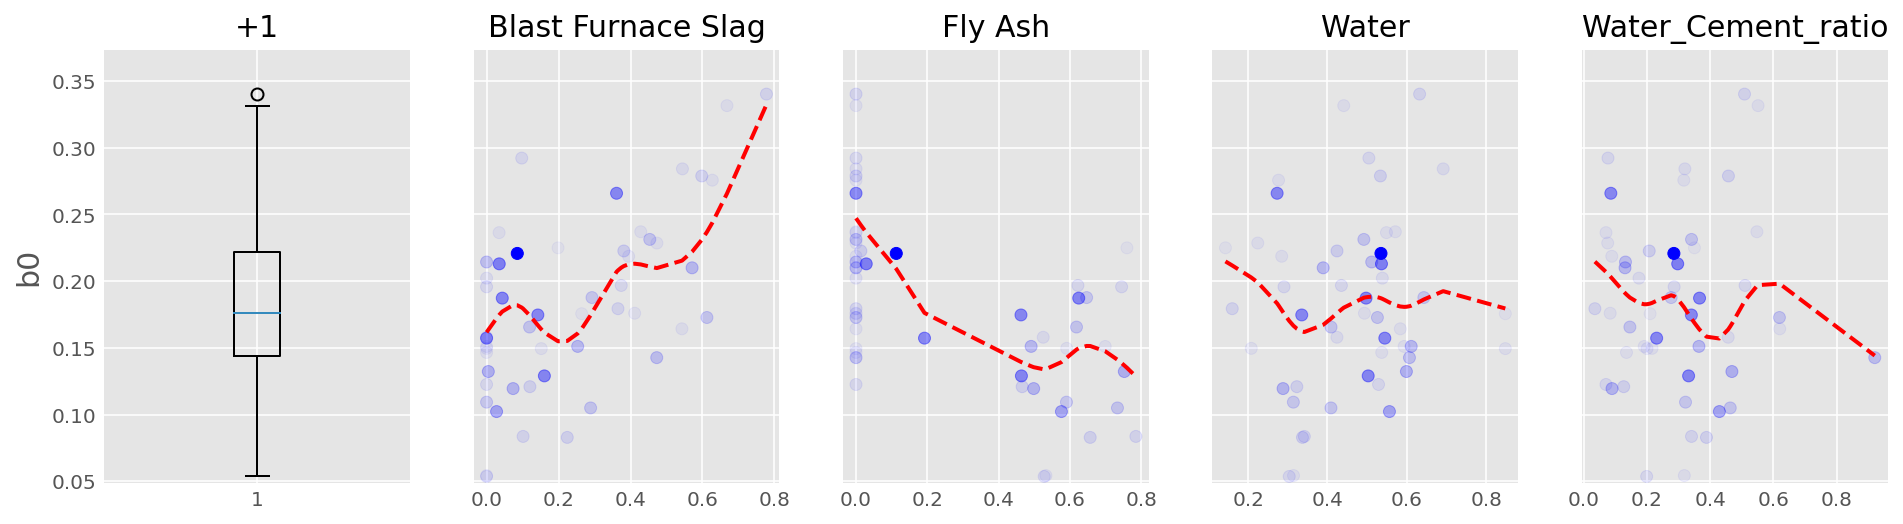

In [83]:
clf.intercept_plot(feature_idx=[2, 3, 4, 9], nllms=50, figsize=(16, 4))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  """Entry point for launching an IPython kernel.


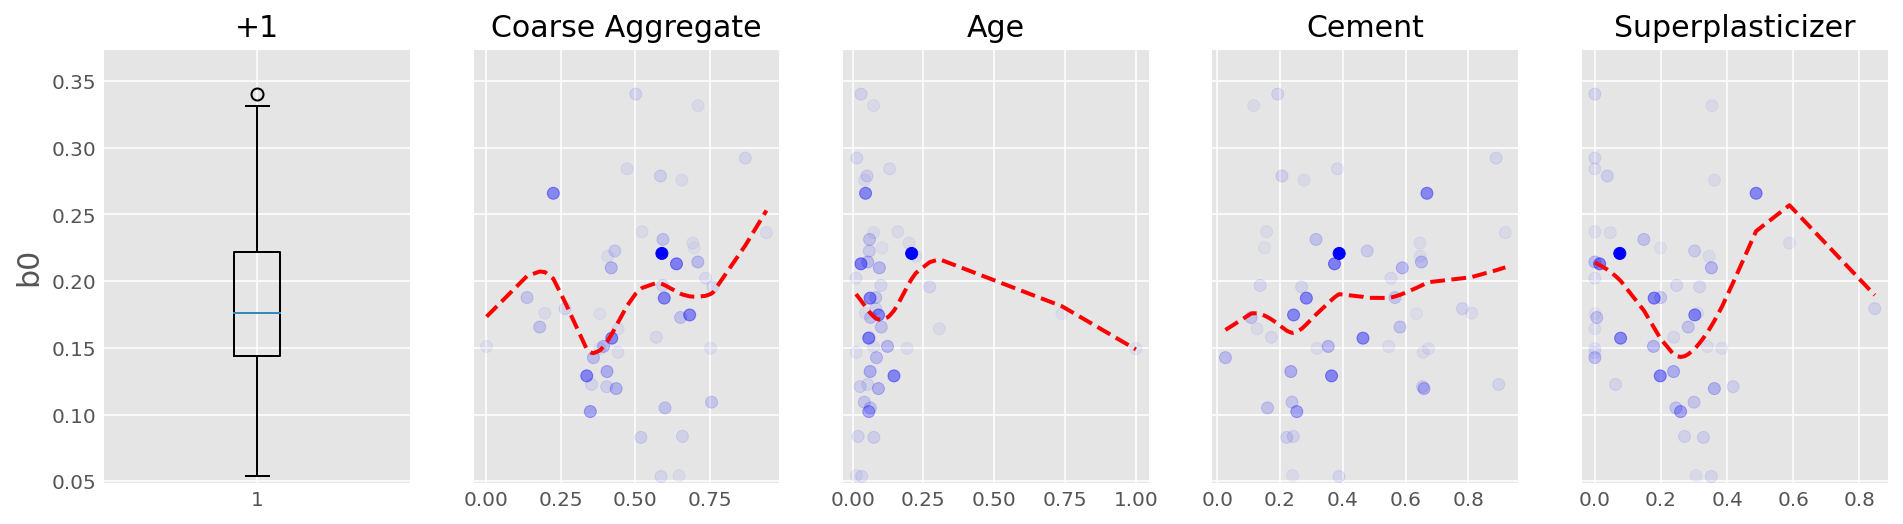

In [57]:
clf.intercept_plot(feature_idx=[6, 8, 1, 5], nllms=50, figsize=(16, 4))

## Local Inference from the MLP Regressor 

In [59]:
clf.local_inference_wald(0)

Count              78.000000
Response Mean      33.234359
Response Std       11.198257
Local MSE        1225.827346
Global MSE       1582.730352
Name: 0, dtype: float64


coef    std err         t   p-value      [0.025     0.975]
b0   2.961247  31.498181  0.094013  0.925375  -59.892395  65.814889
x1  18.353509  28.242575  0.649853  0.517977  -38.003671  74.710689
x2  28.700517  14.103546  2.034986  0.045753    0.557328  56.843706
x3  38.121079   8.467525  4.502033  0.000027   21.224396  55.017761
x4  42.784674  21.592037  1.981502  0.051580   -0.301565  85.870913
x5  28.092818  14.375353  1.954235  0.054787   -0.592752  56.778389
x6   0.445067  11.662745  0.038161  0.969671  -22.827577  23.717712
x7   8.622490  13.040714  0.661198  0.510720  -17.399850  34.644830
x8  18.932611   8.066038  2.347201  0.021834    2.837084  35.028139
x9 -60.851189  30.815786 -1.974676  0.052367 -122.343132   0.640754

## Local Inference plots for DNN 

Count              78.000000
Response Mean      33.234359
Response Std       11.198257
Local MSE        1225.827346
Global MSE       1582.730352
Name: 0, dtype: float64


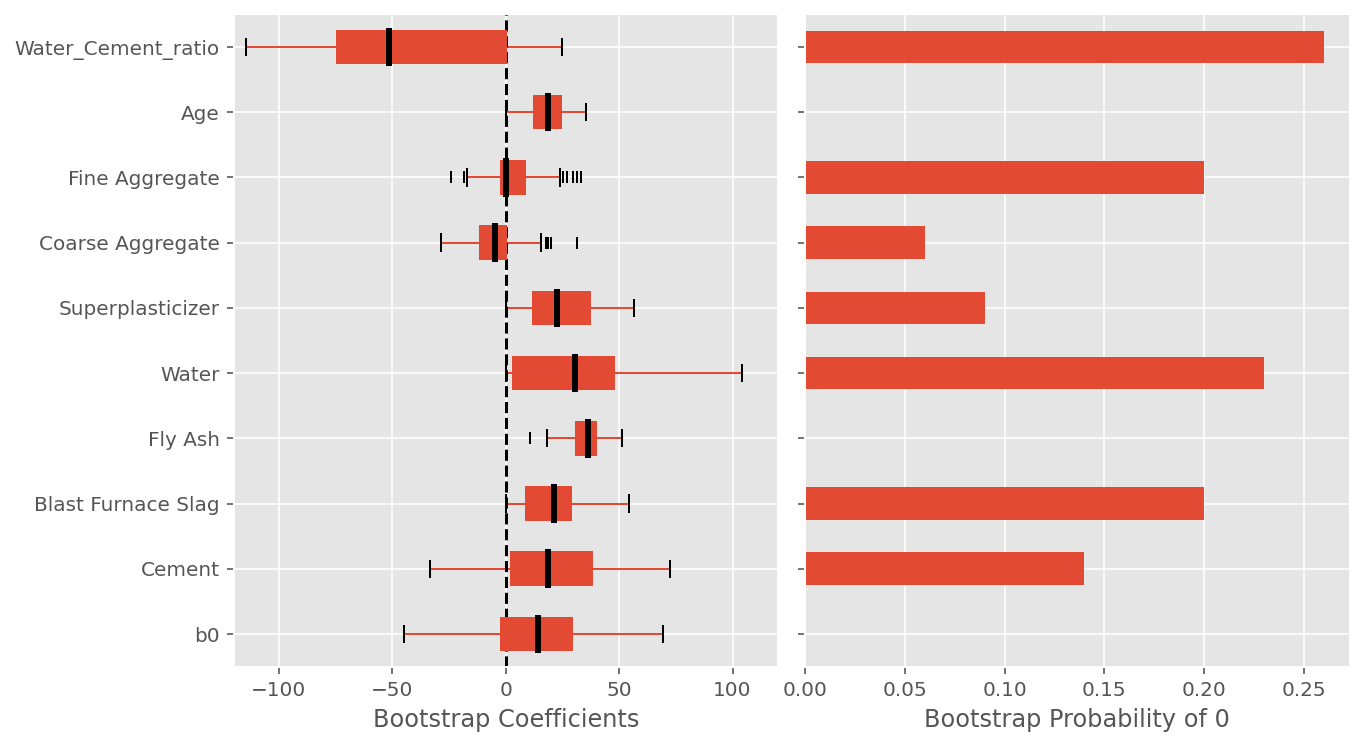

In [60]:

clf.local_inference_bootstrap(0)

## Local and Global Mean Square Error for DNN plot 

In [61]:
len(np.where(clf.ystd_llms == 0)[0]) / clf.nllms

0.4013605442176871

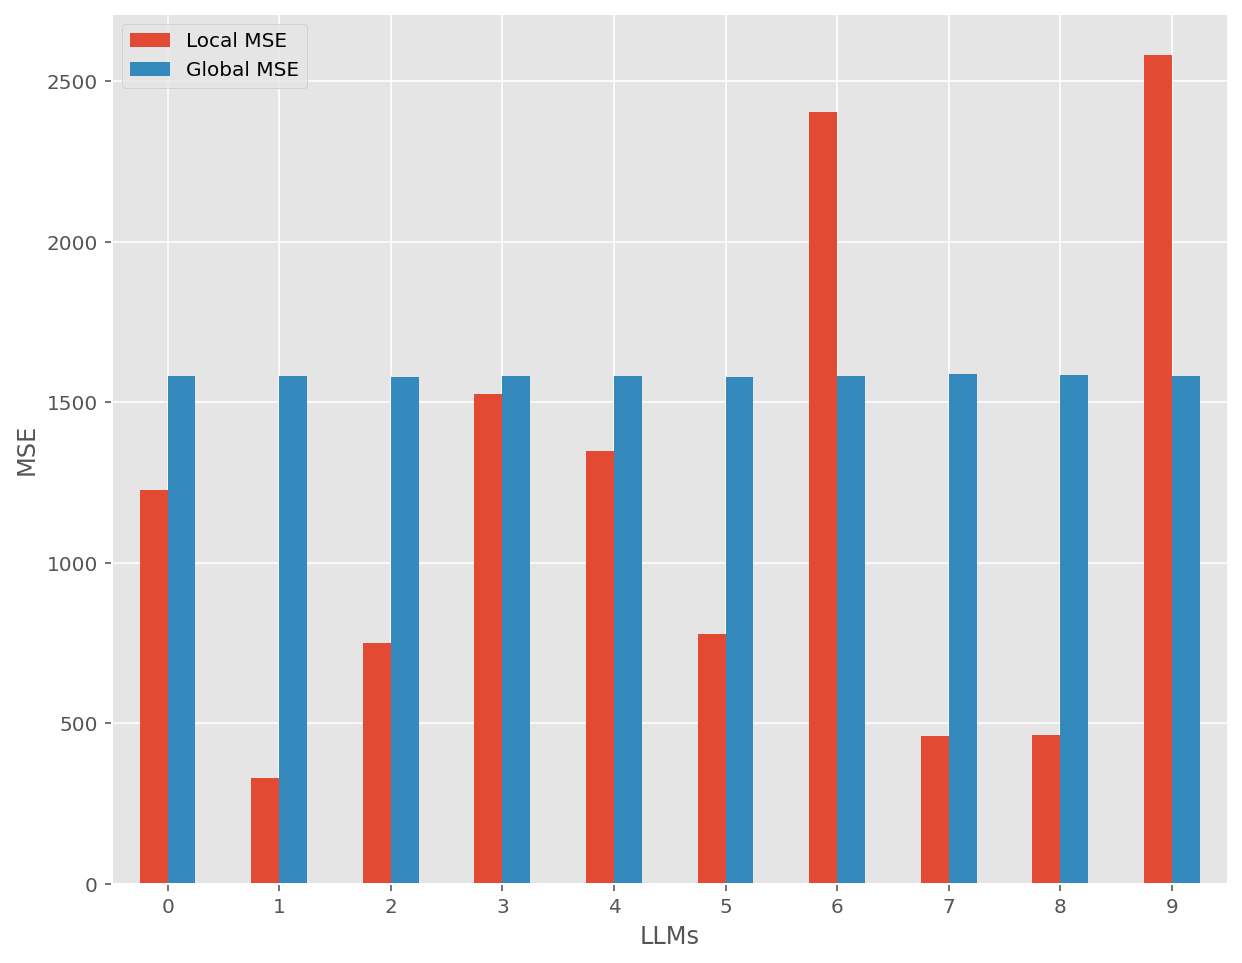

In [62]:

clf.diagperf_bar(nllms=10, figsize=(10, 8))

## Prallel Coordinte plot for LLM the coeficients 

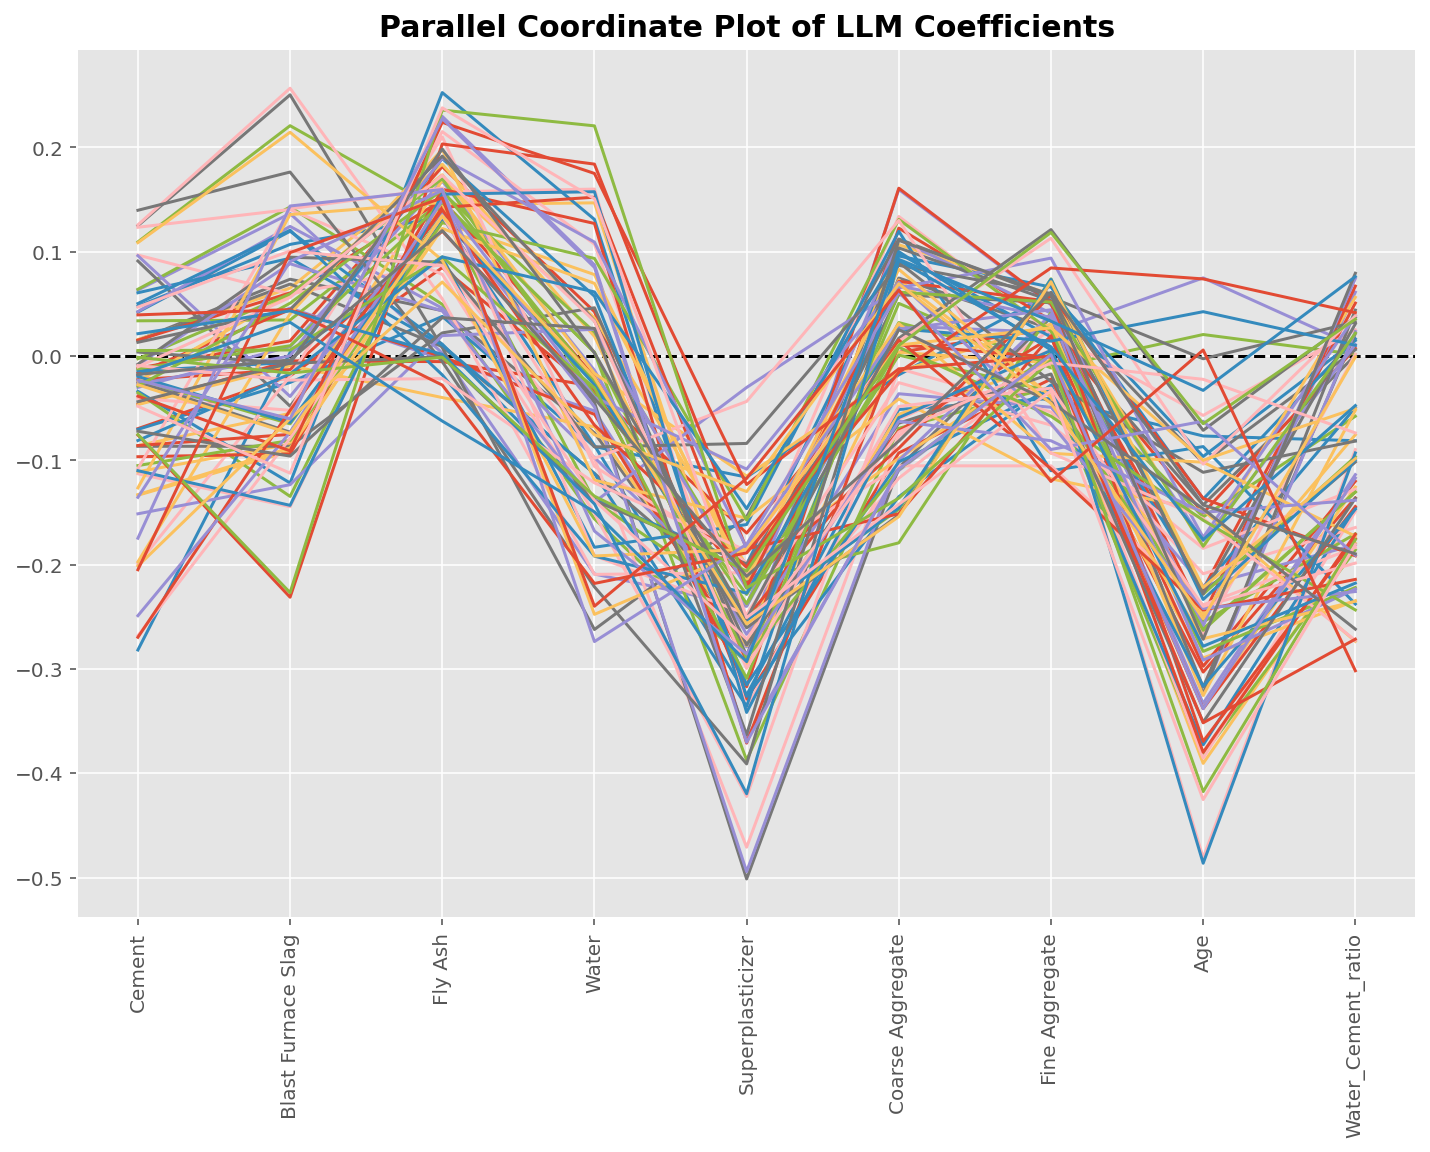

In [81]:
clf.pc_plot(figsize=(12, 8),xlabel_rotation=90)

## Polar Coordinate  Plot of the Coefficients 

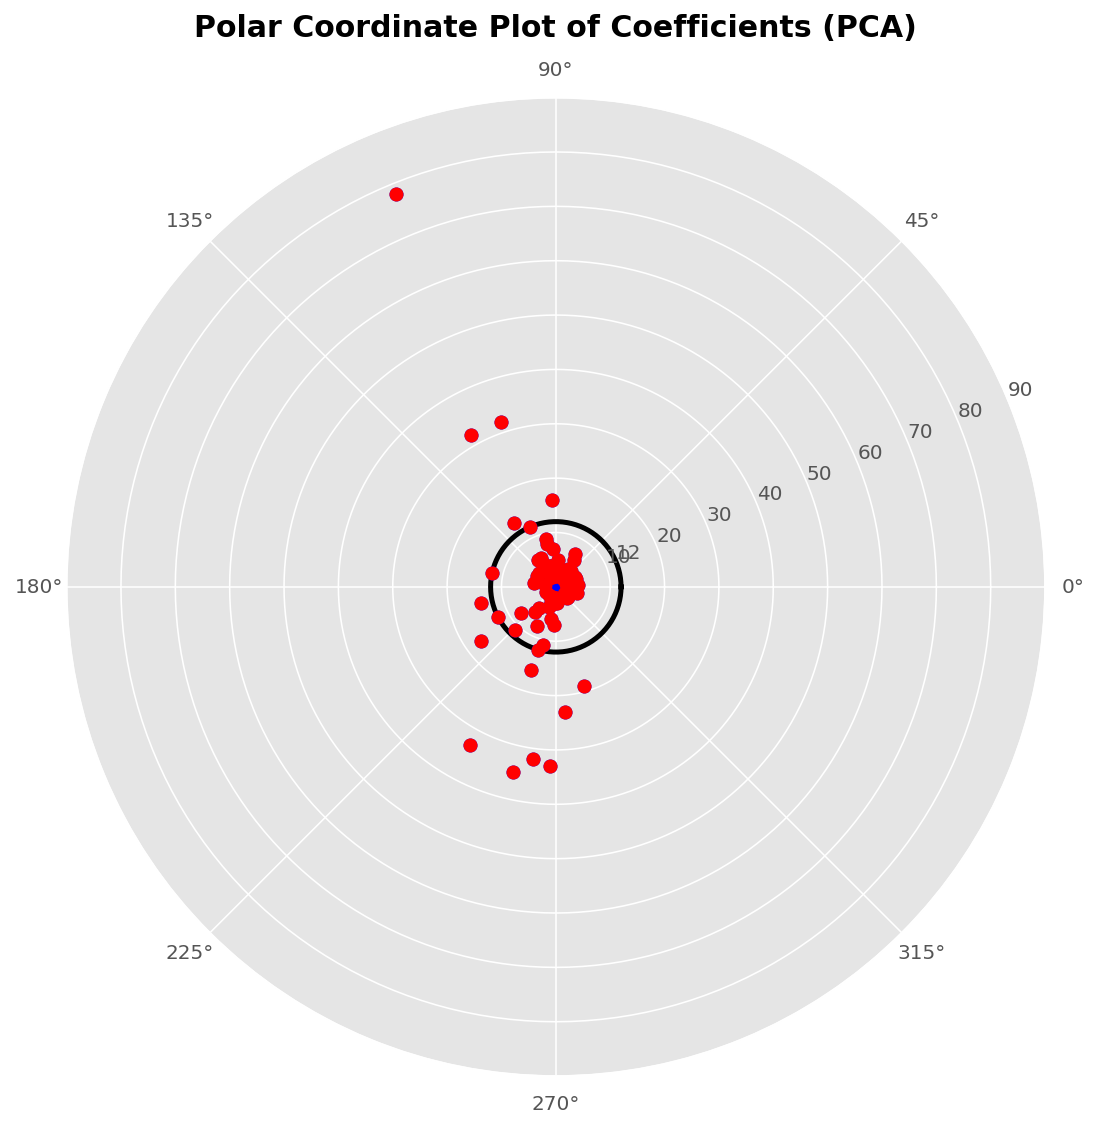

In [70]:

clf.polar_plot(min_samples=12, figsize=(9, 9))

## Feature Importance plots for parameters 

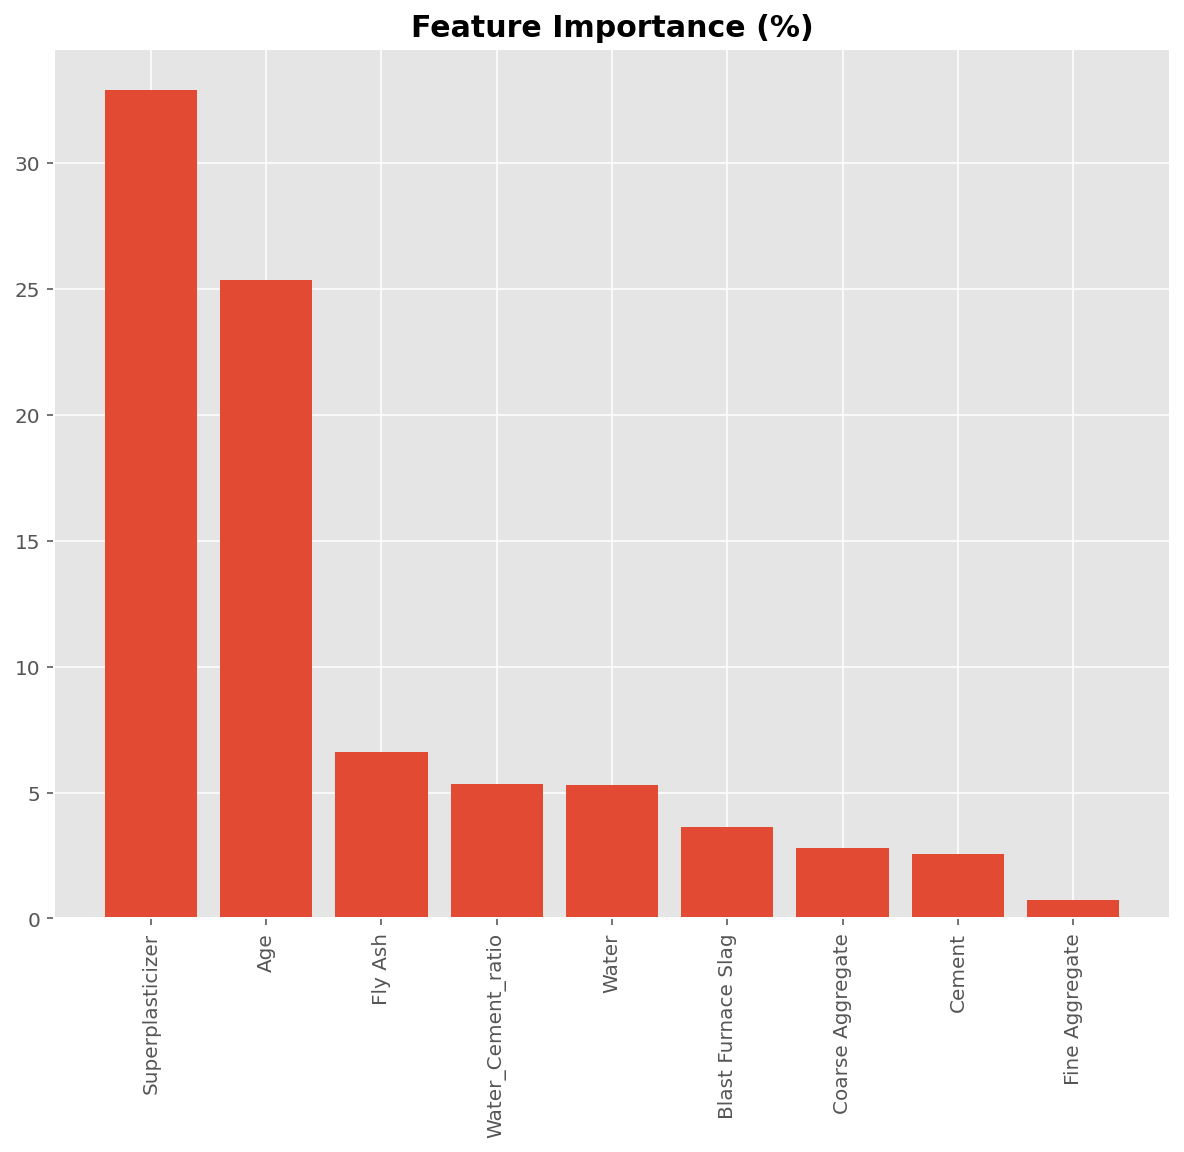

In [80]:

clf.feature_importance_plot(figsize=(10, 8),xlabel_rotation=90)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

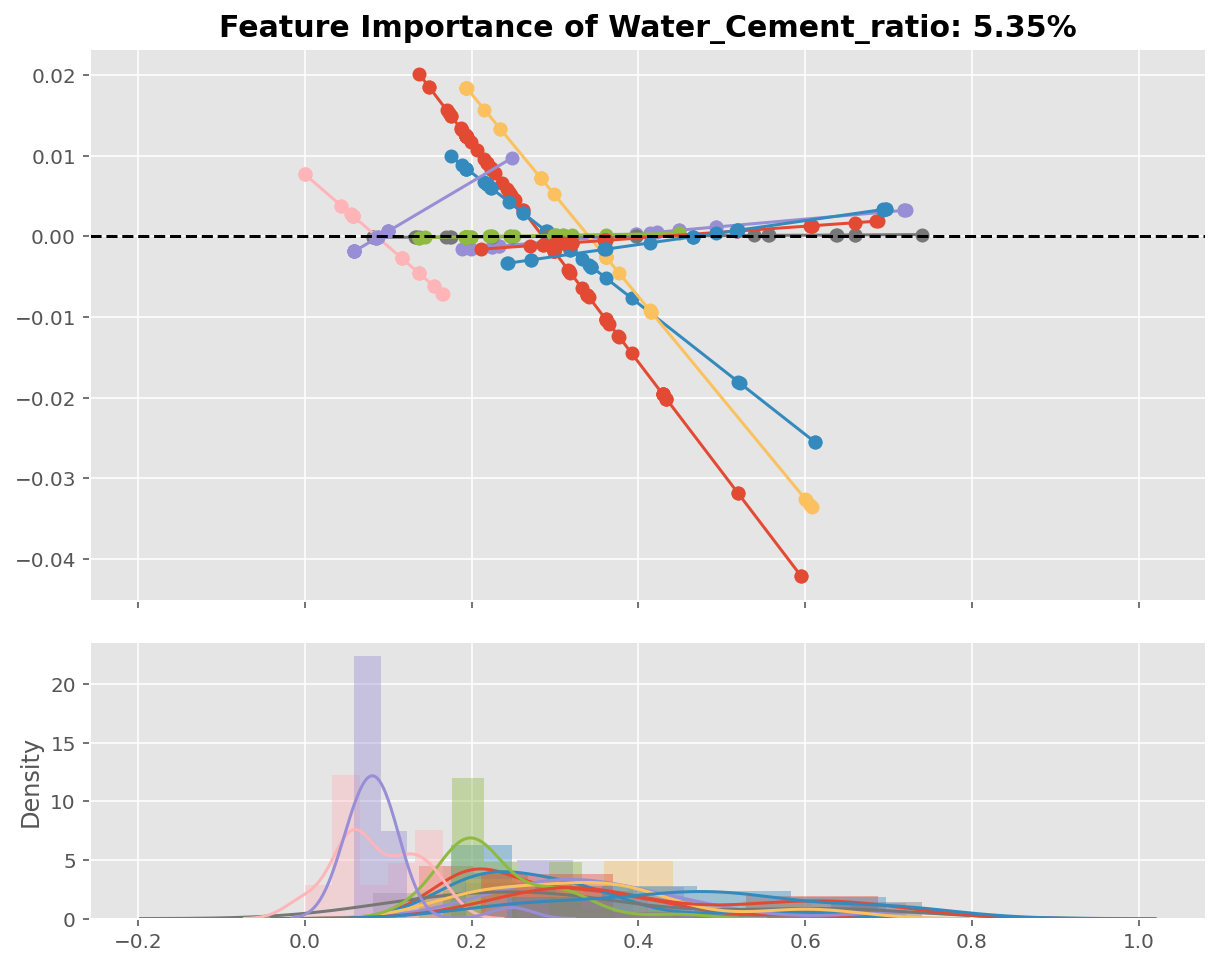

In [73]:
clf.profile_plot(feature_id=9, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

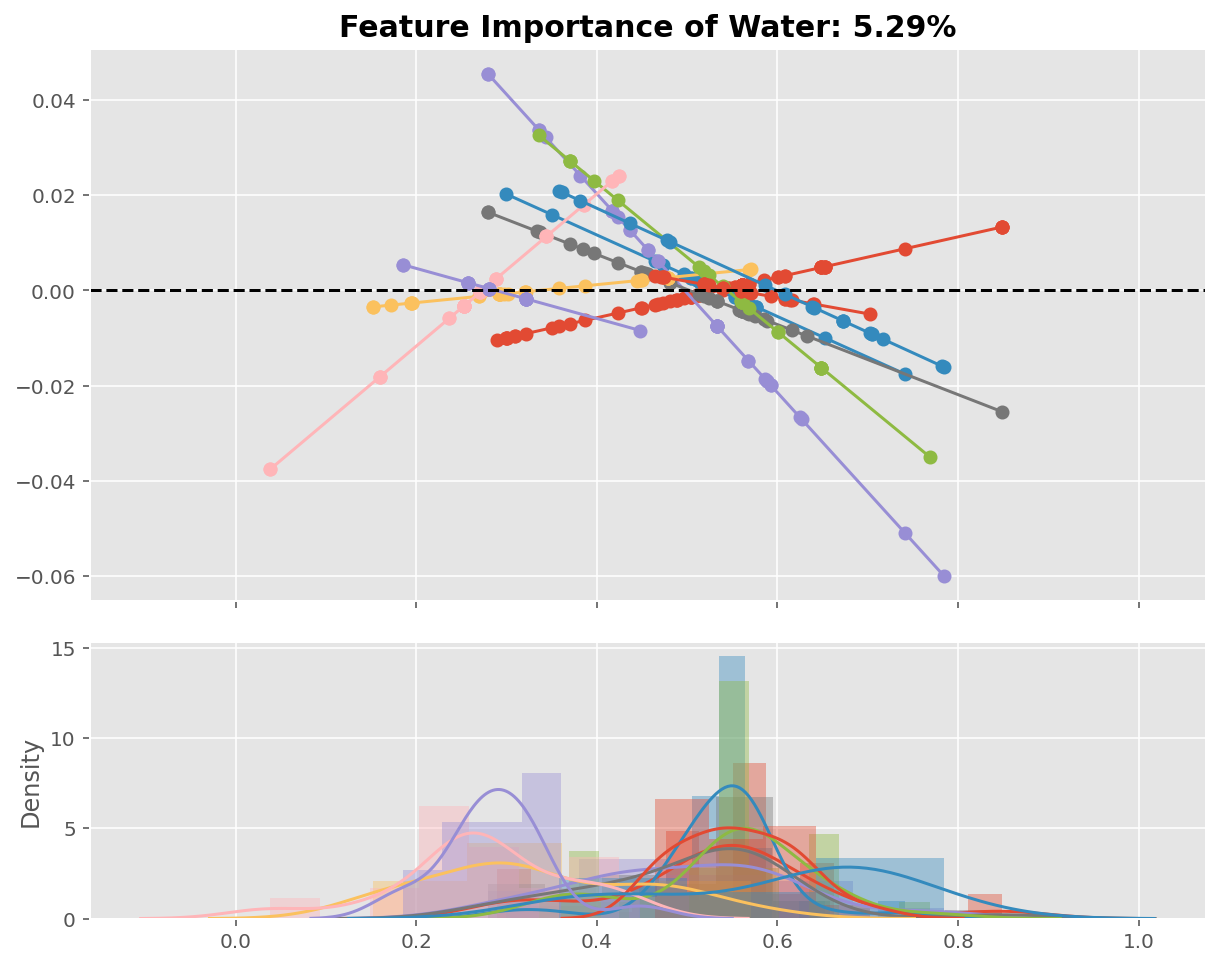

In [76]:
clf.profile_plot(feature_id=4, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

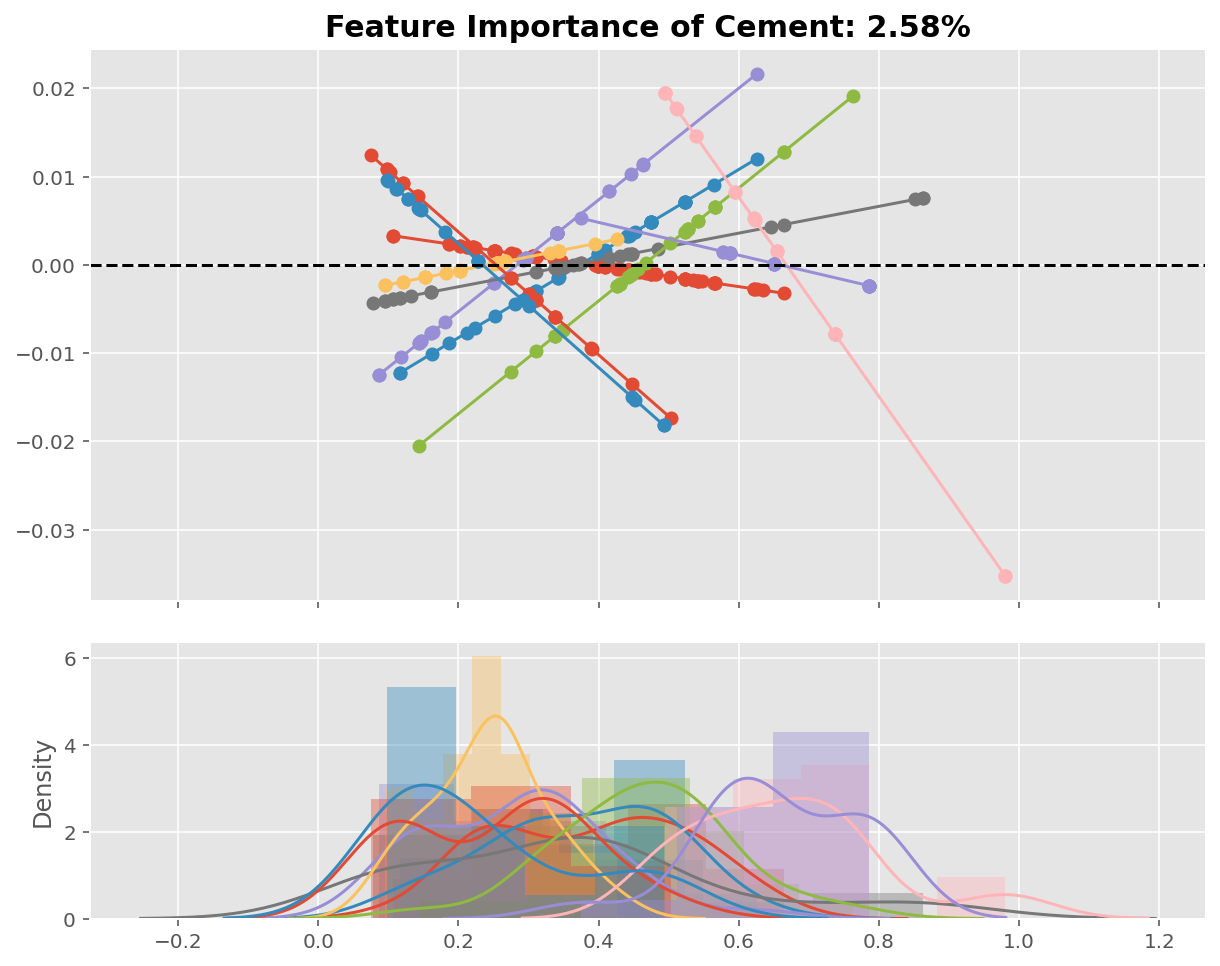

In [74]:
clf.profile_plot(feature_id=1, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

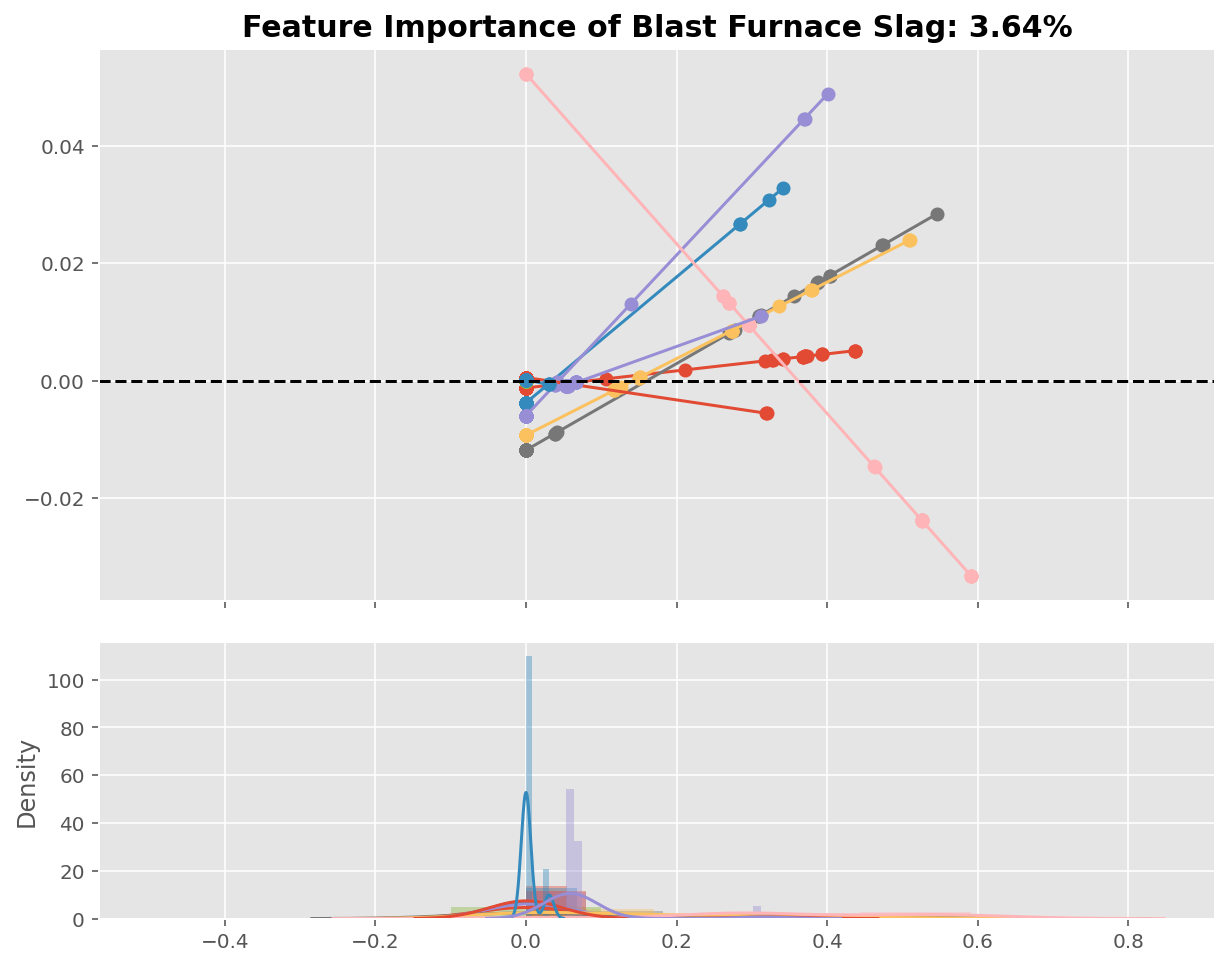

In [75]:
clf.profile_plot(feature_id=2, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

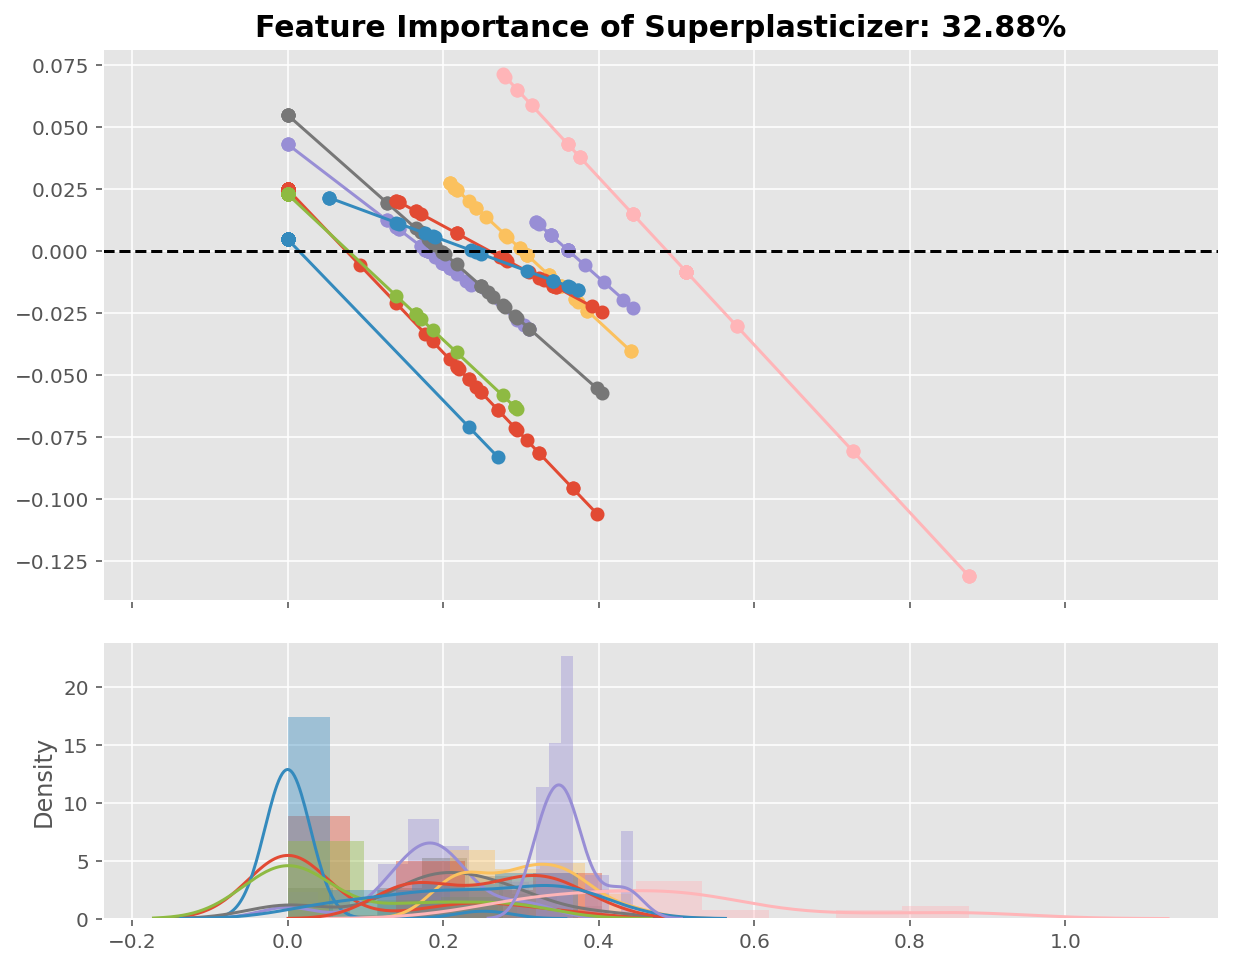

In [87]:
clf.profile_plot(feature_id=5, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

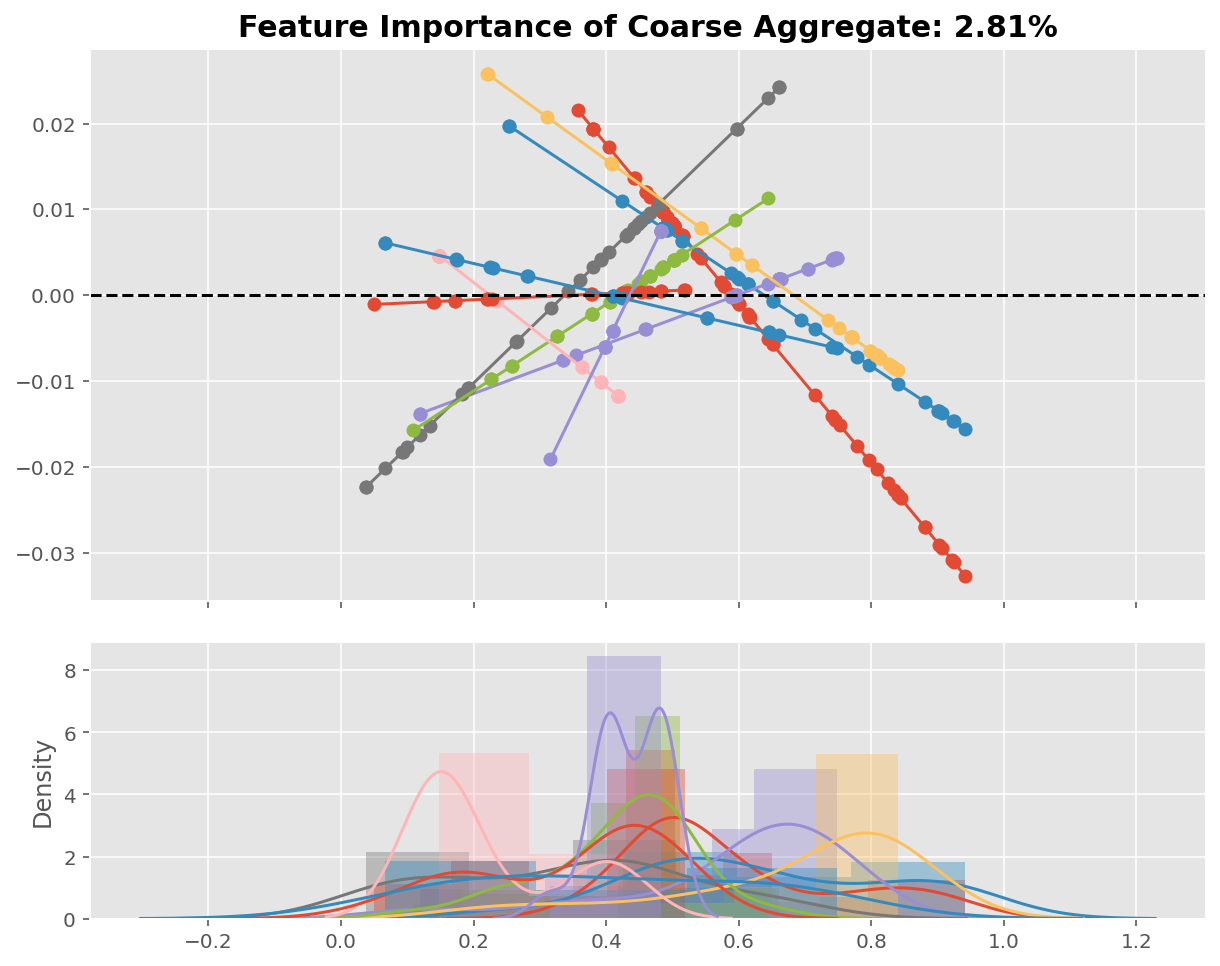

In [72]:
clf.profile_plot(feature_id=6, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

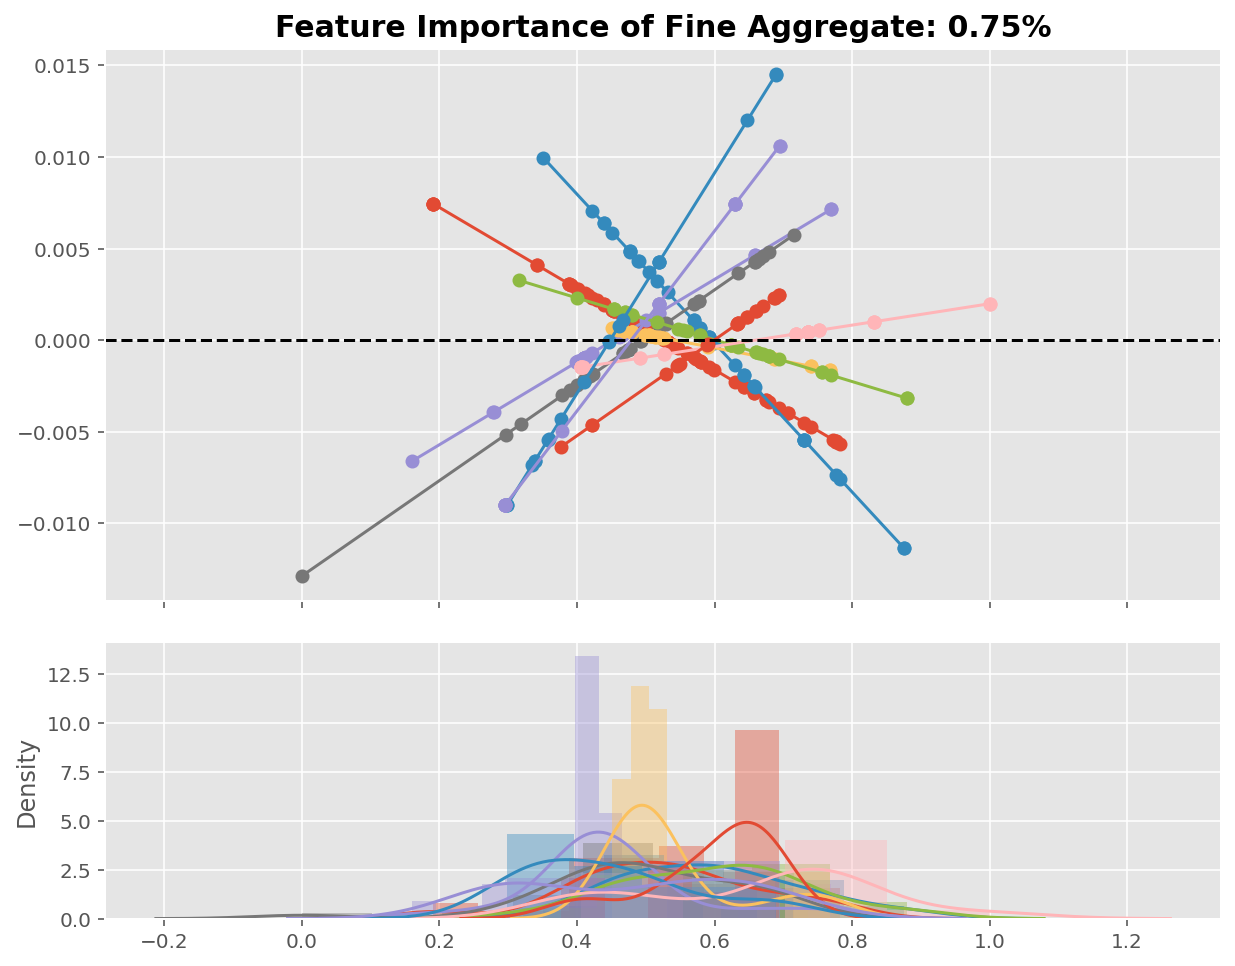

In [77]:
clf.profile_plot(feature_id=7, nllms=10, figsize=(10, 8))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

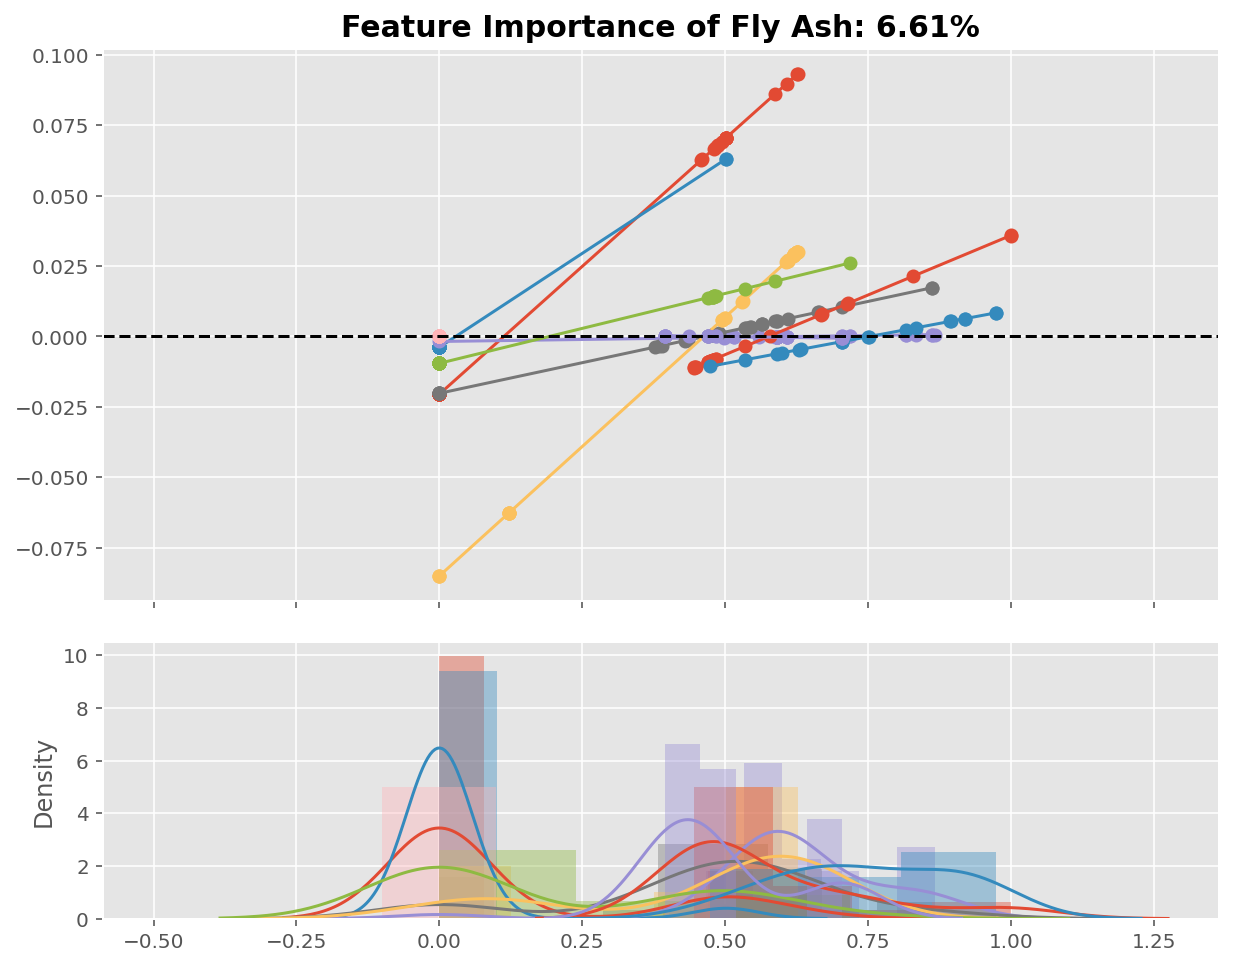

In [79]:
clf.profile_plot(feature_id=3, nllms=10, figsize=(10, 8))